<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression

In [2]:
file_path = 'data/cleaned_data_no_injured.xlsx'
# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2021-08-11,M-3,0,2021-2022,SEASON,7423.0,426.0,20,52.0,38.0,...,34,63.0,36.0,19,80.35,0,1,0,0,0
1,2021-08-12,M-2,0,2021-2022,SEASON,1268.0,0.0,0,11.0,5.0,...,54,115.0,74.0,43,171.20,0,1,0,0,0
2,2021-08-13,M-1,0,2021-2022,SEASON,4135.0,112.0,2,47.0,20.0,...,54,126.0,79.0,43,214.78,0,1,0,0,0
3,2021-08-15,M+1,0,2021-2022,SEASON,6379.0,86.0,0,49.0,48.0,...,56,173.0,99.0,54,273.13,0,1,0,0,0
4,2021-08-17,M-4,0,2021-2022,SEASON,6287.0,209.0,9,62.0,44.0,...,56,222.0,147.0,67,352.61,0,1,0,0,0


Chequear desbalanceo de clases

In [3]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4663
Lesión: 37
Porcentaje de lesionados en el dataset: 0.79%


# Correlation of variables

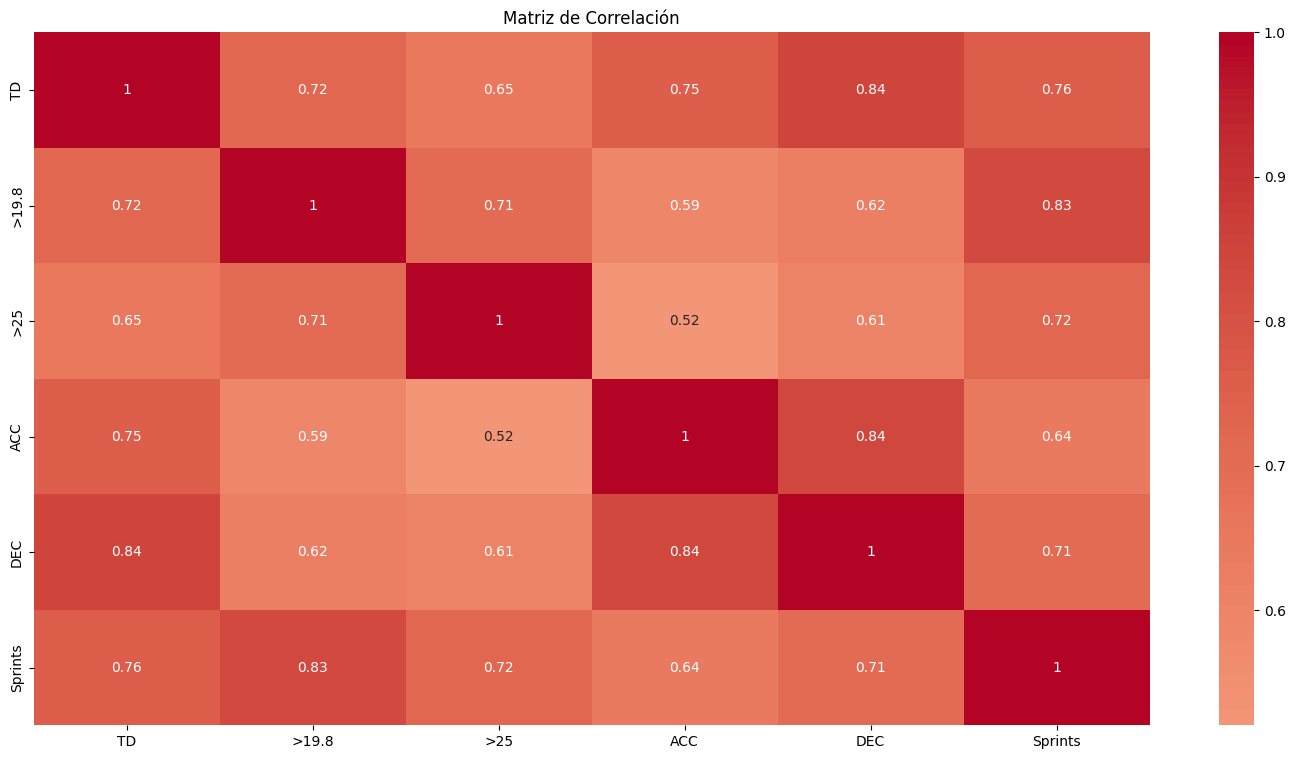

In [10]:
metrics = ['TD', '>19.8',
       '>25', 'ACC', 'DEC', 'Sprints']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [11]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

  Variable       VIF
0    const  7.536370
1       TD  4.628723
2    >19.8  3.719300
3      >25  2.396270
4      ACC  3.594287
5      DEC  5.476943
6  Sprints  4.365045


# Filtrar datos por fecha o temporada


In [4]:
df_filtered = df[df['season']=='2022-2023']
df_filtered.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25-21,ACC-21,DEC-21,Sprints-21,Mins-21,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
138,2022-06-20,NaN,0,2022-2023,PRESEASON,7219.0,224.0,1,57.0,21.0,...,0,0.0,0.0,0,0.00,0,1,0,0,0
139,2022-06-21,NaN,0,2022-2023,PRESEASON,5511.0,113.0,6,68.0,35.0,...,1,57.0,21.0,15,81.69,0,1,0,0,0
140,2022-06-22,NaN,0,2022-2023,PRESEASON,6553.0,27.0,0,96.0,34.0,...,7,125.0,56.0,23,154.86,0,1,0,0,0
141,2022-06-23,NaN,0,2022-2023,PRESEASON,13058.0,267.0,17,90.0,63.0,...,7,221.0,90.0,26,249.01,0,1,0,0,0
142,2022-06-24,NaN,0,2022-2023,PRESEASON,6716.0,232.0,33,75.0,45.0,...,24,311.0,153.0,40,327.12,0,1,0,0,0


In [5]:
df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

In [6]:
print("No Lesión: " + str(df_filtered[df_filtered["Injury"] == 0].shape[0]))
print("Lesión: " + str(df_filtered[df_filtered["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df_filtered[df_filtered['Injury'] == 1].shape[0] / df_filtered.shape[0]) * 100):.2f}%")

No Lesión: 2441
Lesión: 23
Porcentaje de lesionados en el dataset: 0.93%


# ML Modelos

## Separate data into X, y and player_ids

In [7]:
df_filtered.columns

Index(['DATE', 'Microcycle', 'Injury', 'season', 'preseason-season', 'TD',
       '>19.8', '>25', 'ACC', 'DEC', 'PlayerID', 'Max Speed', 'Sprints',
       'Mins', 'Max Speed Season', 'Avg Speed Season', '% Max Speed',
       'Speed Diff Max Avg', 'TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'Mins-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'Mins-21', 'Position_CENTREBACK',
       'Position_CENTREMIDFIELDER', 'Position_FULLBACK', 'Position_STRIKER',
       'Position_WINGER'],
      dtype='object')

In [8]:
metrics_train = ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

print(len(metrics_train))

24


In [9]:
df_sorted = df_filtered.sort_values(by='DATE', ascending=False)

## Split data

### Split by first %30

In [100]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for 20% testing
split_index = int(0.3 * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index]
X_train = X.iloc[split_index:]
y_test = y.iloc[:split_index]
y_train = y.iloc[split_index:]
extra_cols_test = extra_cols.iloc[:split_index]
extra_cols_train = extra_cols.iloc[split_index:]

### Split random 

In [15]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, player_ids_train, player_ids_test = train_test_split(X, y, player_ids, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.2, random_state=42)

## Smote

In [101]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_train , y_train = smote.fit_resample(X_train, y_train)

# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    1705
1    1705
Name: count, dtype: int64
Injury
0    1705
1    1705
Name: count, dtype: int64


## Logistic Regression

In [77]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
# Initialize datasets
X_all = X_train_scaled  # Scaled features
y_all = y_train.values  # Labels

# Start with a small labeled dataset from the bottom of the sorted DataFrame
initial_samples = 450  # Number of initial samples
X_train_active = X_all[-initial_samples:]  # Select the last `initial_samples` rows
y_train_active = y_all[-initial_samples:]  # Corresponding labels

# Remaining unlabeled pool (everything except the selected rows)
X_pool = X_all[:-initial_samples]
y_pool = y_all[:-initial_samples]

print(f"Initial training set size: {len(X_train_active)}")
print(f"Remaining pool size: {len(X_pool)}")

Initial training set size: 450
Remaining pool size: 1275


Iteration 1/300:
Training Recall for Label 1: 1.0000
Training Size: 453
Iteration 2/300:
Training Recall for Label 1: 1.0000
Training Size: 456
Iteration 3/300:
Training Recall for Label 1: 1.0000
Training Size: 459
Iteration 4/300:
Training Recall for Label 1: 1.0000
Training Size: 462
Iteration 5/300:
Training Recall for Label 1: 1.0000
Training Size: 465
Iteration 6/300:
Training Recall for Label 1: 1.0000
Training Size: 468
Iteration 7/300:
Training Recall for Label 1: 1.0000
Training Size: 471
Iteration 8/300:
Training Recall for Label 1: 1.0000
Training Size: 474
Iteration 9/300:
Training Recall for Label 1: 1.0000
Training Size: 477
Iteration 10/300:
Training Recall for Label 1: 1.0000
Training Size: 480
Iteration 11/300:
Training Recall for Label 1: 0.5000
Training Size: 483
Iteration 12/300:
Training Recall for Label 1: 1.0000
Training Size: 486
Iteration 13/300:
Training Recall for Label 1: 1.0000
Training Size: 489
Iteration 14/300:
Training Recall for Label 1: 1.0000
Traini

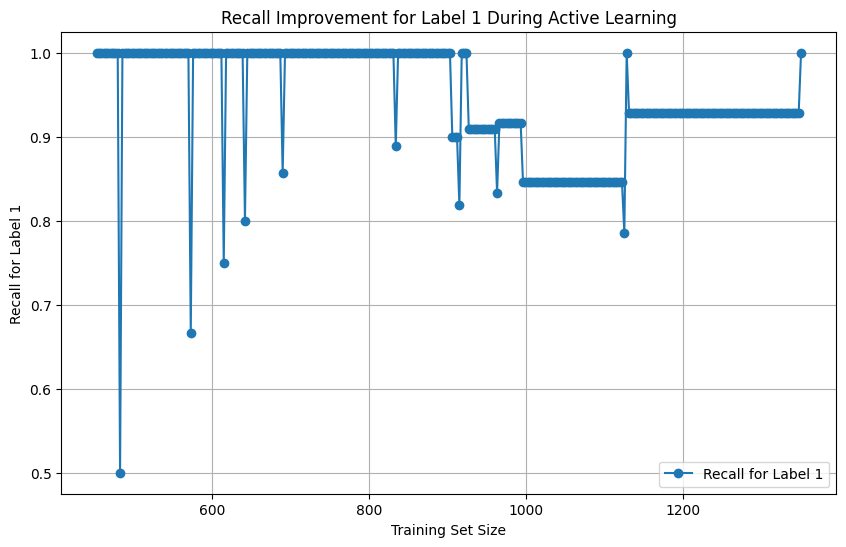

In [79]:
# Parameters for active learning
n_iterations = 300  # Number of active learning iterations
samples_per_iteration = 3  # Samples to add in each iteration

# To store metrics for visualization
train_recall_label1_scores = []
train_sizes = []

for i in range(n_iterations):
    # Train the model on the current labeled dataset
    logistic_model.fit(X_train_active, y_train_active)
    
    # Predict probabilities for the unlabeled pool
    probs = logistic_model.predict_proba(X_pool)[:, 1]
    
    # Find the most uncertain samples (probabilities closest to 0.5)
    uncertainty = np.abs(probs - 0.5)  # Uncertainty measure
    uncertain_indices = np.argsort(uncertainty)[:samples_per_iteration]
    
    # Add the most uncertain samples to the training set
    X_train_active = np.vstack((X_train_active, X_pool[uncertain_indices]))
    y_train_active = np.hstack((y_train_active, y_pool[uncertain_indices]))
    
    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Evaluate recall for label 1
    y_train_pred = logistic_model.predict(X_train_active)
    recall_label1 = recall_score(y_train_active, y_train_pred, pos_label=1)  # Focus on label 1
    train_recall_label1_scores.append(recall_label1)
    train_sizes.append(len(y_train_active))
    
    print(f"Iteration {i + 1}/{n_iterations}:")
    print(f"Training Recall for Label 1: {recall_label1:.4f}")
    print(f"Training Size: {len(y_train_active)}")
    
    
# Plot recall improvement for label 1
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_recall_label1_scores, marker='o', label="Recall for Label 1")
plt.xlabel("Training Set Size")
plt.ylabel("Recall for Label 1")
plt.title("Recall Improvement for Label 1 During Active Learning")
plt.legend()
plt.grid()
plt.show()

In [80]:
# Evaluate on test data
y_test_pred = logistic_model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Evaluation:
Accuracy: 0.8700947225981055
Confusion Matrix:
 [[643  93]
 [  3   0]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.87      0.93       736
           1       0.00      0.00      0.00         3

    accuracy                           0.87       739
   macro avg       0.50      0.44      0.47       739
weighted avg       0.99      0.87      0.93       739



In [81]:
# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_prob = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.7327536231884058
Confusion Matrix:
 [[1248  457]
 [   4   16]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.73      0.84      1705
           1       0.03      0.80      0.06        20

    accuracy                           0.73      1725
   macro avg       0.52      0.77      0.45      1725
weighted avg       0.99      0.73      0.84      1725


Test Set Evaluation:
Accuracy: 0.7090663058186739
Confusion Matrix:
 [[524 212]
 [  3   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83       736
           1       0.00      0.00      0.00         3

    accuracy                           0.71       739
   macro avg       0.50      0.36      0.41       739
weighted avg       0.99      0.71      0.83       739



Number of unique thresholds: 11

Optimal Threshold: 0.27

Evaluation with Optimal Threshold:
Accuracy: 0.40866035182679294
Confusion Matrix:
 [[299 437]
 [  0   3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.41      0.58       736
           1       0.01      1.00      0.01         3

    accuracy                           0.41       739
   macro avg       0.50      0.70      0.30       739
weighted avg       1.00      0.41      0.58       739



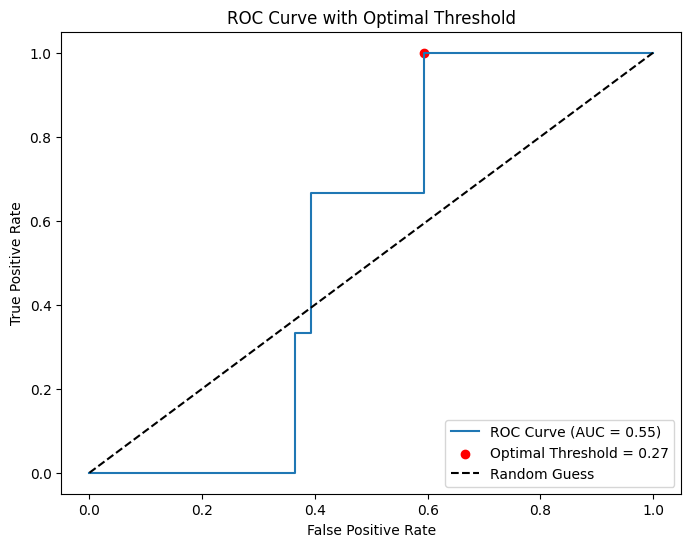

In [82]:
# ROC curve and optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

# Check unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Find the optimal threshold
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold: {optimal_threshold:.2f}")

# Apply the optimal threshold
y_test_pred_optimal = (y_test_prob >= optimal_threshold).astype(int)

# Evaluate with the optimal threshold
print("\nEvaluation with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_optimal))
print("Classification Report:\n", classification_report(y_test, y_test_pred_optimal))

# Plot the ROC curve with the optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color="red", label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()

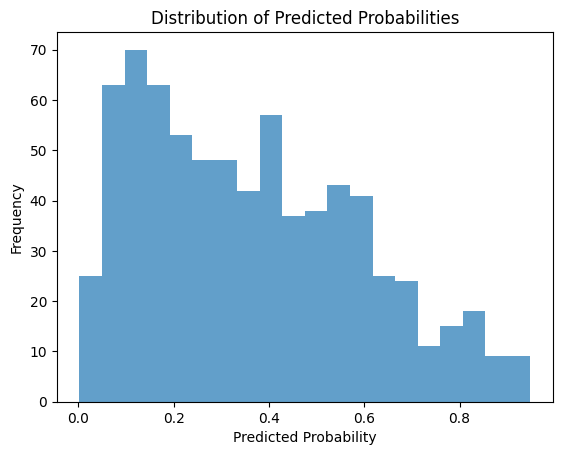

In [83]:
plt.hist(y_test_prob, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [84]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_prob,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Calculate the probability manually (for verification)
df_a['Calculated_Score'] = 1 / (1 + np.exp(-df_a['Linear_Combination']))

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()



Player, Date, Feature Contributions, Linear Combination, and Score DataFrame:


,Player,Date,Score,Actual,TD-1,Coeff_TD-1,>19.8-1,Coeff_>19.8-1,>25-1,Coeff_>25-1,...,>25-21,Coeff_>25-21,ACC-21,Coeff_ACC-21,DEC-21,Coeff_DEC-21,Sprints-21,Coeff_Sprints-21,Linear_Combination,Calculated_Score
0,87583,2023-05-10,0.116950,0,0.000000,3.32774,0.000000,-4.332204,0.0,-2.412383,...,0.000000,2.833607,0.075758,2.541737,0.110569,0.898695,0.036585,-3.20237,-2.021631,0.116950
1,23085,2023-05-10,0.131771,0,0.000000,3.32774,0.000000,-4.332204,0.0,-2.412383,...,0.000000,2.833607,0.088235,2.541737,0.066057,0.898695,0.017073,-3.20237,-1.885388,0.131771
2,89871,2023-05-09,0.110572,0,0.000000,3.32774,0.000000,-4.332204,0.0,-2.412383,...,0.127929,2.833607,0.259358,2.541737,0.220528,0.898695,0.024390,-3.20237,-2.084907,0.110572
3,87583,2023-05-08,0.106373,0,0.000000,3.32774,0.000000,-4.332204,0.0,-2.412383,...,0.000000,2.833607,0.036542,2.541737,0.052642,0.898695,0.009756,-3.20237,-2.128331,0.106373
4,12086,2023-05-08,0.330309,0,0.252386,3.32774,0.050827,-4.332204,0.0,-2.412383,...,0.238988,2.833607,0.508021,2.541737,0.610772,0.898695,0.565854,-3.20237,-0.706790,0.330309


In [85]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

       Feature  Importance
0         TD-1    3.327740
20      >25-21    2.833607
4        DEC-1    2.723135
17   Sprints-7    2.564362
21      ACC-21    2.541737
12        TD-7    2.061443
5    Sprints-1    1.400939
15       ACC-7    1.058953
14       >25-7    1.053505
16       DEC-7    0.981621
22      DEC-21    0.898695
6         TD-3    0.685239
18       TD-21    0.590803
11   Sprints-3    0.507253
13     >19.8-7    0.198830
8        >25-3   -0.053318
10       DEC-3   -1.349398
3        ACC-1   -2.001224
7      >19.8-3   -2.205042
2        >25-1   -2.412383
9        ACC-3   -2.827708
23  Sprints-21   -3.202370
19    >19.8-21   -4.058405
1      >19.8-1   -4.332204


In [86]:
# Extract top features by absolute importance
num_top_features = 8  # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 8 Features: ['TD-1' '>25-21' 'DEC-1' 'Sprints-7' 'ACC-21' 'TD-7' 'Sprints-1' 'ACC-7']


In [87]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

Updated Model Evaluation:
Accuracy: 0.6265223274695535
Confusion Matrix:
 [[460 276]
 [  0   3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.62      0.77       736
           1       0.01      1.00      0.02         3

    accuracy                           0.63       739
   macro avg       0.51      0.81      0.40       739
weighted avg       1.00      0.63      0.77       739



Optimal Threshold: 0.44

Evaluation with Optimal Threshold:
Accuracy: 0.4884979702300406
Confusion Matrix:
 [[358 378]
 [  0   3]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.49      0.65       736
           1       0.01      1.00      0.02         3

    accuracy                           0.49       739
   macro avg       0.50      0.74      0.34       739
weighted avg       1.00      0.49      0.65       739



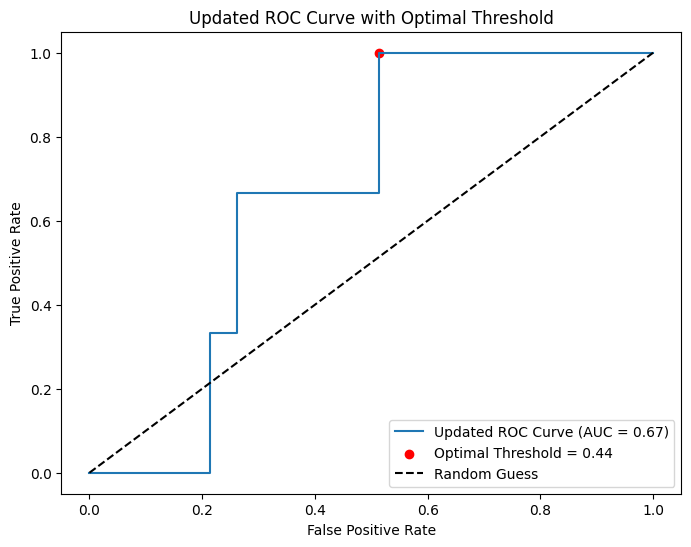

In [23]:
# Get probabilities for the updated model
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Calculate ROC curve and AUC
fpr_top, tpr_top, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc_top = auc(fpr_top, tpr_top)

# Find the optimal threshold (maximize TPR - FPR)
optimal_idx = (tpr_top - fpr_top).argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# Apply the optimal threshold to make predictions
y_test_pred_optimal = (y_test_probs_top >= optimal_threshold).astype(int)

# Evaluate performance with the optimal threshold
print("\nEvaluation with Optimal Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_optimal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_optimal))
print("Classification Report:\n", classification_report(y_test, y_test_pred_optimal))

# Plot ROC curve with the optimal threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr_top, tpr_top, label=f"Updated ROC Curve (AUC = {roc_auc_top:.2f})")
plt.scatter(fpr_top[optimal_idx], tpr_top[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Updated ROC Curve with Optimal Threshold")
plt.legend(loc="lower right")
plt.show()

## SVM

In [349]:
# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.738 total time=   2.2s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.725 total time=   2.1s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.775 total time=   2.1s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.760 total time=   2.2s
[CV 5/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.810 total time=   2.0s
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.669 total time=   1.4s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.642 total time=   1.4s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.450 total time=   1.5s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.614 total time=   1.5s
[CV 5/5] END C=0.01, class_weight=

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.63      0.77       878
           1       0.00      0.00      0.00         4

    accuracy                           0.63       882
   macro avg       0.50      0.32      0.39       882
weighted avg       0.99      0.63      0.77       882

Test Set AUC: 0.3670273348519362


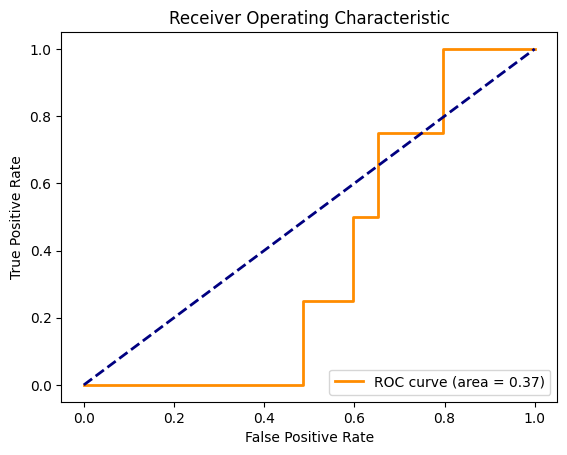

In [352]:
# Standardize the features
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight="balanced", gamma='auto',probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

Use GridSearch to find the best hyperparameters

In [102]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 5,              # L1 regularization
    'gamma': 5,              # Minimum loss reduction
    'max_depth': 3,
    'learning_rate': 0.09,
    'n_estimators': 100
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=20,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

Selected Features (RFE): ['TD-1', '>19.8-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', 'DEC-21', 'Sprints-21']
Number of features selected: 20


In [90]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.07, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [200, 300, 400],
    'scale_pos_weight': [10,12,15],
    'alpha': [0, 1, 5],
    'gamma': [0, 1, 5],
}

# scaler = StandardScaler()
# X_train_selected = scaler.fit_transform(X_train_selected)
# X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


KeyboardInterrupt: 

## Train the model with the best parameters

In [122]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

param_grid = {
   'learning_rate': 0.01,  # Explore smaller learning rates
   'max_depth': 17,             # Test broader depth values
   'n_estimators': 300,     # Include larger estimators
   'scale_pos_weight': 10,
   'alpha': 7,  # L5 regularization
   'gamma': 7,  # Minimum loss reduction
}


# Train the final model
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.50
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Final Test ROC-AUC: 0.7826
Accuracy: 0.7429
Precision: 0.0105
Recall: 0.6667
F1 Score: 0.0206
Confusion Matrix:
[[547 189]
 [  1   2]]


## Transform test data

In [205]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
player_ids_test = player_ids_test.reset_index(drop=True)

In [206]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': player_ids_test,  # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '+25 Km/h-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics



Test ROC-AUC: 0.8348


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]